# Model Decay
Last updated by Developer on 2024-10-15.

**NOTE**: This notebook needs to be run on a VM so that the yield curve redis can be accessed which is necessary for `process_data(...)`. The error that will be raised otherwise is a `TimeoutError`.

This notebook allows one to see the importance of re-training the deployed model every day by showing that a stale model becomes inaccurate over time. The user specifies a `START_DATE` and an `END_DATE` for the experiment. The baseline yield spread model and baseline dollar price model is the yield spread model and the dollar price model respectively deployed after the end of day on the specified start date. The specified end date is the last day of data that is considered in this experiment. For each day, the baseline model is tested against the up-to-date model, which is the model that was deployed on that day. The accuracy of each model is compared. To get the predictions for the baseline model, isolate the trades after this model has trained and get predictions for all of these trades. 

The archived model `model-02-04` is a model that was trained with data until `02-02` and tested on data on `02-03` before being deployed for use on `02-04`.

**NOTE**: We only consider trades that are priced by the yield spread model.

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from pytz import timezone
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import USFederalHolidayCalendar    # used to create a business day defined on the US federal holiday calendar that can be added or subtracted to a datetime

from google.cloud import bigquery

from sklearn import preprocessing
from tensorflow import keras

In [2]:
from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, NUM_OF_DAYS_IN_YEAR
from ficc.utils.auxiliary_functions import function_timer, sqltodf, get_ys_trade_history_features, get_dp_trade_history_features
from ficc.utils.nelson_siegel_model import yield_curve_level
from ficc.utils.diff_in_days import diff_in_days_two_dates

Initializing pandarallel with 5.0 cores
INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/user/ficc/ficc/mitas_creds.json'

In [ ]:
BUSINESS_DAY = CustomBusinessDay(calendar=USFederalHolidayCalendar())    # used to skip over holidays when adding or subtracting business days

In [ ]:
PROJECT_ID = 'eng-reactor-287421'
DATASET_NAME = 'yield_curves_v2'

In [4]:
START_DATE = '2023-10-24'   # earliest date for which we have been tracking historical pricing
END_DATE = '2023-11-14'   # '2023-12-31'

In [5]:
EASTERN = timezone('US/Eastern')

In [6]:
START_DATE_WITH_START_OF_DAY_TIMESTAMP = START_DATE + 'T00:00:00'
END_DATE_WITH_END_OF_DAY_TIMESTAMP = END_DATE + 'T23:59:59'

`QUERY_FEATURES`, `ADDITIONAL_QUERY_FEATURES_FOR_DOLLAR_PRICE_MODEL`, `QUERY_CONDITIONS`, and `ADDITIONAL_QUERY_CONDITIONS_FOR_YIELD_SPREAD_MODEL` are taken directly from `automated_training_auxiliary_functions.py` with no modifications.

In [7]:
QUERY_FEATURES = ['rtrs_control_number',
                  'cusip',
                  'yield',
                  'is_callable',
                  'refund_date',
                  'accrual_date',
                  'dated_date',
                  'next_sink_date',
                  'coupon',
                  'delivery_date',
                  'trade_date',
                  'trade_datetime',
                  'par_call_date',
                  'interest_payment_frequency',
                  'is_called',
                  'is_non_transaction_based_compensation',
                  'is_general_obligation',
                  'callable_at_cav',
                  'extraordinary_make_whole_call',
                  'make_whole_call',
                  'has_unexpired_lines_of_credit',
                  'escrow_exists',
                  'incorporated_state_code',
                  'trade_type',
                  'par_traded',
                  'maturity_date',
                  'settlement_date',
                  'next_call_date',
                  'issue_amount',
                  'maturity_amount',
                  'issue_price',
                  'orig_principal_amount',
                  'max_amount_outstanding',
                  'recent',
                  'dollar_price',
                  'calc_date',
                  'purpose_sub_class',
                  'called_redemption_type',
                  'calc_day_cat',
                  'previous_coupon_payment_date',
                  'instrument_primary_name',
                  'purpose_class',
                  'call_timing',
                  'call_timing_in_part',
                  'sink_frequency',
                  'sink_amount_type',
                  'issue_text',
                  'state_tax_status',
                  'series_name',
                  'transaction_type',
                  'next_call_price',
                  'par_call_price',
                  'when_issued',
                  'min_amount_outstanding',
                  'original_yield',
                  'par_price',
                  'default_indicator',
                  'sp_stand_alone',
                  'sp_long',
                  'moodys_long',
                  'coupon_type',
                  'federal_tax_status',
                  'use_of_proceeds',
                  'muni_security_type',
                  'muni_issue_type',
                  'capital_type',
                  'other_enhancement_type',
                  'next_coupon_payment_date',
                  'first_coupon_date',
                  'last_period_accrues_from_date']
ADDITIONAL_QUERY_FEATURES_FOR_DOLLAR_PRICE_MODEL = ['refund_price', 'publish_datetime', 'maturity_description_code']    # these features were used for testing, but are not needed, nonetheless, we keep them since the previous data files have these fields and `pd.concat(...)` will fail if the column set is different

QUERY_CONDITIONS = ['par_traded >= 10000', 
                    'coupon_type in (8, 4, 10, 17)', 
                    'capital_type <> 10', 
                    'default_exists <> TRUE', 
                    'most_recent_default_event IS NULL', 
                    'default_indicator IS FALSE', 
                    'msrb_valid_to_date > current_date',    # condition to remove cancelled trades
                    'settlement_date IS NOT NULL']
ADDITIONAL_QUERY_CONDITIONS_FOR_YIELD_SPREAD_MODEL = ['yield IS NOT NULL', 'yield > 0']

Get all of the trades after the start date and up to and including the end date. The `get_data_query(...)` function is taken directly from `automated_training_auxiliary_functions.py` with minor modifications. The `get_data(...)` function is taken from the function `get_new_data(...)` in `automated_tarining_auxiliary_functions.py` with major modifications.

In [8]:
OPTIONAL_ARGUMENTS_FOR_PROCESS_DATA = {'use_treasury_spread': True, 
                                       'only_dollar_price_history': False}

In [9]:
BQ_CLIENT = bigquery.Client()

In [10]:
TTYPE_DICT = {(0, 0): 'D', (0, 1): 'S', (1, 0): 'P'}

_VARIANTS = ['max_qty', 'min_ago', 'D_min_ago', 'P_min_ago', 'S_min_ago']
YS_VARIANTS = ['max_ys', 'min_ys'] + _VARIANTS
DP_VARIANTS = ['max_dp', 'min_dp'] + _VARIANTS
_FEATS = ['_ttypes', '_ago', '_qdiff']
YS_FEATS = ['_ys'] + _FEATS
DP_FEATS = ['_dp'] + _FEATS

LONG_TIME_AGO_IN_NUM_SECONDS = 9    # default `num_seconds_ago` value to signify that the trade was a long time ago (9 is a large value since the `num_seconds_ago` is log10 transformed)

In [11]:
D_prev = dict()
P_prev = dict()
S_prev = dict()


def _trade_history_derived_features(row, model: str, use_treasury_spread: bool = False):
    assert model in ('yield_spread', 'dollar_price'), f'Invalid value for model: {model}'
    if model == 'yield_spread':
        variants = YS_VARIANTS
        trade_history_features = get_ys_trade_history_features(use_treasury_spread)
    else:
        variants = DP_VARIANTS
        trade_history_features = get_dp_trade_history_features()

    ys_or_dp_idx = trade_history_features.index(model)
    par_traded_idx = trade_history_features.index('par_traded')
    trade_type1_idx = trade_history_features.index('trade_type1')
    trade_type2_idx = trade_history_features.index('trade_type2')
    seconds_ago_idx = trade_history_features.index('seconds_ago')


    def extract_feature_from_trade(row, name, trade):    # `name` is used solely for debugging
        ys_or_dp = trade[ys_or_dp_idx]
        ttypes = TTYPE_DICT[(trade[trade_type1_idx], trade[trade_type2_idx])] + row.trade_type
        seconds_ago = trade[seconds_ago_idx]
        quantity_diff = np.log10(1 + np.abs(10**trade[par_traded_idx] - 10**row.quantity))
        return [ys_or_dp, ttypes, seconds_ago, quantity_diff]


    global D_prev
    global S_prev
    global P_prev
    
    trade_history_feature_name = 'trade_history' if model == 'yield_spread' else 'trade_history_dollar_price'
    trade_history = row[trade_history_feature_name]
    most_recent_trade = trade_history[0]
    
    D_min_ago_t = D_prev.get(row.cusip, most_recent_trade)
    D_min_ago = LONG_TIME_AGO_IN_NUM_SECONDS        

    P_min_ago_t = P_prev.get(row.cusip, most_recent_trade)
    P_min_ago = LONG_TIME_AGO_IN_NUM_SECONDS
    
    S_min_ago_t = S_prev.get(row.cusip, most_recent_trade)
    S_min_ago = LONG_TIME_AGO_IN_NUM_SECONDS
    
    max_ys_or_dp_t = most_recent_trade
    max_ys_or_dp = most_recent_trade[ys_or_dp_idx]
    min_ys_or_dp_t = most_recent_trade
    min_ys_or_dp = most_recent_trade[ys_or_dp_idx]
    max_qty_t = most_recent_trade
    max_qty = most_recent_trade[par_traded_idx]
    min_ago_t = most_recent_trade
    min_ago = most_recent_trade[seconds_ago_idx]
    
    for trade in trade_history:
        seconds_ago = trade[seconds_ago_idx]
        # Checking if the first trade in the history is from the same block; TODO: shouldn't this be checked for every trade?
        if seconds_ago == 0: continue

        ys_or_dp = trade[ys_or_dp_idx]
        if ys_or_dp > max_ys_or_dp: 
            max_ys_or_dp_t = trade
            max_ys_or_dp =ys_or_dp
        elif ys_or_dp < min_ys_or_dp: 
            min_ys_or_dp_t = trade
            min_ys_or_dp = ys_or_dp

        par_traded = trade[par_traded_idx]
        if par_traded > max_qty: 
            max_qty_t = trade 
            max_qty = par_traded

        if seconds_ago < min_ago:    # TODO: isn't this just the most recent trade not in the same block, and isn't this initialized above already?
            min_ago_t = trade
            min_ago = seconds_ago
            
        side = TTYPE_DICT[(trade[trade_type1_idx], trade[trade_type2_idx])]
        if side == 'D':
            if seconds_ago < D_min_ago: 
                D_min_ago_t = trade
                D_min_ago = seconds_ago
                D_prev[row.cusip] = trade
        elif side == 'P':
            if seconds_ago < P_min_ago: 
                P_min_ago_t = trade
                P_min_ago = seconds_ago
                P_prev[row.cusip] = trade
        elif side == 'S':
            if seconds_ago < S_min_ago: 
                S_min_ago_t = trade
                S_min_ago = seconds_ago
                S_prev[row.cusip] = trade
        else: 
            print('invalid side', trade)
    
    variant_trade_dict = dict(zip(variants, [max_ys_or_dp_t, min_ys_or_dp_t, max_qty_t, min_ago_t, D_min_ago_t, P_min_ago_t, S_min_ago_t]))
    variant_trade_list = []
    for variant_name, variant_trade in variant_trade_dict.items():
        feature_list = extract_feature_from_trade(row, variant_name, variant_trade)
        variant_trade_list += feature_list
    return variant_trade_list

In [12]:
def trade_history_derived_features_yield_spread(use_treasury_spread):
    return lambda row: _trade_history_derived_features(row, 'yield_spread', use_treasury_spread)
def trade_history_derived_features_dollar_price(row):
    return _trade_history_derived_features(row, 'dollar_price')

In [13]:
def get_trade_history_columns(model: str):
    '''Creates a list of columns.'''
    assert model in ('yield_spread', 'dollar_price'), f'Model should be either yield_spread or dollar_price, but was instead: {model}'
    if model == 'yield_spread':
        variants = YS_VARIANTS
        feats = YS_FEATS
    else:
        variants = DP_VARIANTS
        feats = DP_FEATS
    
    columns = []
    for prefix in variants:
        for suffix in feats:
            columns.append(prefix + suffix)
    return columns

In [14]:
@function_timer
def add_trade_history_derived_features(data: pd.DataFrame, model: str, use_treasury_spread: bool = False):
    assert model in ('yield_spread', 'dollar_price'), f'Invalid value for model: {model}'
    data.sort_values('trade_datetime', inplace=True)    # when calling `trade_history_derived_features...(...)` the order of trades needs to be ascending for `trade_datetime`
    trade_history_derived_features = trade_history_derived_features_yield_spread(use_treasury_spread) if model == 'yield_spread' else trade_history_derived_features_dollar_price
    trade_history_feature_name = 'trade_history' if model == 'yield_spread' else 'trade_history_dollar_price'
    
    temp = data[['cusip', trade_history_feature_name, 'quantity', 'trade_type']].parallel_apply(trade_history_derived_features, axis=1)
    cols = get_trade_history_columns(model)
    data[cols] = pd.DataFrame(temp.tolist(), index=data.index)
    del temp

    data.sort_values('trade_datetime', ascending=False, inplace=True)
    return data


@function_timer
def drop_features_with_null_value(df: pd.DataFrame, features: list):
    # df = df.dropna(subset=features)
    for feature in features:    # perform the procedure feature by feature to output how many trades are being removed for each feature
        num_trades_before = len(df)
        df = df.dropna(subset=[feature])
        num_trades_after = len(df)
        if num_trades_before != num_trades_after: print(f'Removed {num_trades_before - num_trades_after} trades for having a null value in feature: {feature}')
    return df

In [ ]:
YEAR_MONTH_DAY = '%Y-%m-%d'

NUM_TRADES_IN_HISTORY_YIELD_SPREAD_MODEL = 5
NUM_TRADES_IN_HISTORY_DOLLAR_PRICE_MODEL = 2


def get_data_query(features, conditions):
    features_as_string = ', '.join(features)
    conditions = conditions + [f'trade_datetime > "{START_DATE_WITH_START_OF_DAY_TIMESTAMP}"', 
                               f'trade_datetime < "{END_DATE_WITH_END_OF_DAY_TIMESTAMP}"']
    conditions_as_string = ' AND '.join(conditions)
    return f'''SELECT {features_as_string}
               FROM `eng-reactor-287421.auxiliary_views_v2.trade_history_same_issue_5_yr_mat_bucket_1_materialized`
               WHERE {conditions_as_string}
               ORDER BY trade_datetime desc'''


def get_data(model: str, use_treasury_spread: bool = False, optional_arguments_for_process_data: dict = {}, raw_data_filepath: str = None):
    assert model in ('yield_spread', 'dollar_price'), f'Invalid value for model: {model}'
    query_features = QUERY_FEATURES
    query_conditions = QUERY_CONDITIONS
    if model == 'yield_spread':
        query_conditions = ADDITIONAL_QUERY_CONDITIONS_FOR_YIELD_SPREAD_MODEL + query_conditions
    else:
        query_features = query_features + ADDITIONAL_QUERY_FEATURES_FOR_DOLLAR_PRICE_MODEL
    
    DATA_QUERY = get_data_query(query_features, query_conditions)
    file_timestamp = datetime.now(EASTERN).strftime(YEAR_MONTH_DAY + '_%H-%M')

    trade_history_features = get_ys_trade_history_features(use_treasury_spread) if model == 'yield_spread' else get_dp_trade_history_features()
    num_features_for_each_trade_in_history = len(trade_history_features)
    num_trades_in_history = NUM_TRADES_IN_HISTORY_YIELD_SPREAD_MODEL if model == 'yield_spread' else NUM_TRADES_IN_HISTORY_DOLLAR_PRICE_MODEL
    if raw_data_filepath is None: raw_data_filepath = f'raw_data_{file_timestamp}.pkl'
    data = process_data(DATA_QUERY, 
                        BQ_CLIENT, 
                        num_trades_in_history, 
                        num_features_for_each_trade_in_history, 
                        raw_data_filepath, 
                        save_data=True, 
                        **optional_arguments_for_process_data)
    
    if model == 'dollar_price': data_from_last_trade_datetime = data_from_last_trade_datetime.rename(columns={'trade_history': 'trade_history_dollar_price'})    # change the trade history column name to match with `PREDICTORS_DOLLAR_PRICE`
    return data, num_features_for_each_trade_in_history, raw_data_filepath

In [16]:
def get_yield_for_last_duration(row, nelson_params, scalar_params, shape_parameter):
    if pd.isnull(row['last_calc_date'])or pd.isnull(row['last_trade_date']):
        # if there is no last trade, we use the duration of the current bond
        duration = diff_in_days_two_dates(row['maturity_date'], row['trade_date']) / NUM_OF_DAYS_IN_YEAR
        ycl = yield_curve_level(duration, row['trade_date'].date(), nelson_params, scalar_params, shape_parameter) / 100
        return ycl
    duration = diff_in_days_two_dates(row['last_calc_date'], row['last_trade_date']) / NUM_OF_DAYS_IN_YEAR
    ycl = yield_curve_level(duration, row['trade_date'].date(), nelson_params, scalar_params, shape_parameter) / 100
    return ycl


@function_timer
def add_yield_curve(data):
    '''Add 'new_ficc_ycl' field to `data`.'''
    nelson_params = sqltodf(f'SELECT * FROM `{PROJECT_ID}.{DATASET_NAME}.nelson_siegel_coef_daily` ORDER BY date DESC', BQ_CLIENT)
    nelson_params.set_index('date', drop=True, inplace=True)
    nelson_params = nelson_params[~nelson_params.index.duplicated(keep='first')]
    nelson_params = nelson_params.transpose().to_dict()

    scalar_params = sqltodf(f'SELECT * FROM `{PROJECT_ID}.{DATASET_NAME}.standardscaler_parameters_daily` ORDER BY date DESC', BQ_CLIENT)
    scalar_params.set_index('date', drop=True, inplace=True)
    scalar_params = scalar_params[~scalar_params.index.duplicated(keep='first')]
    scalar_params = scalar_params.transpose().to_dict()

    shape_parameter = sqltodf(f'SELECT * FROM `{PROJECT_ID}.{DATASET_NAME}.shape_parameters` ORDER BY Date DESC', BQ_CLIENT)
    shape_parameter.set_index('Date', drop=True, inplace=True)
    shape_parameter = shape_parameter[~shape_parameter.index.duplicated(keep='first')]
    shape_parameter = shape_parameter.transpose().to_dict()

    data['last_trade_date'] = data['last_trade_datetime'].dt.date
    data['new_ficc_ycl'] = data[['last_calc_date',
                                 'last_settlement_date',
                                 'trade_date',
                                 'last_trade_date',
                                 'maturity_date']].parallel_apply(lambda row: get_yield_for_last_duration(row, nelson_params, scalar_params, shape_parameter), axis=1)
    data['new_ficc_ycl'] = data['new_ficc_ycl'] * 100
    return data

In [17]:
def target_trade_processing_for_attention(row):
    trade_mapping = {'D': [0,0], 'S': [0,1], 'P':[1,0]}
    target_trade_features = []
    target_trade_features.append(row['quantity'])
    target_trade_features = target_trade_features + trade_mapping[row['trade_type']]
    return np.tile(target_trade_features, (1, 1))


def replace_ratings_by_standalone_rating(data):
    data.loc[data.sp_stand_alone.isna(), 'sp_stand_alone'] = 'NR'
    data.rating = data.rating.astype('str')
    data.sp_stand_alone = data.sp_stand_alone.astype('str')
    data.loc[(data.sp_stand_alone != 'NR'), 'rating'] = data[(data.sp_stand_alone != 'NR')]['sp_stand_alone'].loc[:]
    return data


@function_timer
def combine_new_data_with_old_data(old_data: pd.DataFrame, new_data: pd.DataFrame, model: str):
    assert model in ('yield_spread', 'dollar_price'), f'Invalid value for model: {model}'
    if new_data is None: return old_data    # there is new data since `last_trade_date`

    num_trades_in_new_data = len(new_data)
    num_trades_in_old_data = 0 if old_data is None else len(old_data)
    print(f'Old data has {num_trades_in_old_data} trades. New data has {num_trades_in_new_data} trades')
    trade_history_feature_name = 'trade_history' if model == 'yield_spread' else 'trade_history_dollar_price'
    num_trades_in_history = NUM_TRADES_IN_HISTORY_YIELD_SPREAD_MODEL if model == 'yield_spread' else NUM_TRADES_IN_HISTORY_DOLLAR_PRICE_MODEL
    print(f'Restricting history to {num_trades_in_history} trades')
    new_data[trade_history_feature_name] = new_data[trade_history_feature_name].apply(lambda x: x[:num_trades_in_history])
    if old_data is not None: old_data[trade_history_feature_name] = old_data[trade_history_feature_name].apply(lambda x: x[:num_trades_in_history])    # done in case `num_trades_in_history` has decreased from before

    new_data = replace_ratings_by_standalone_rating(new_data)
    new_data['yield'] = new_data['yield'] * 100
    if model == 'yield_spread': new_data = add_yield_curve(new_data)
    new_data['target_attention_features'] = new_data.parallel_apply(target_trade_processing_for_attention, axis=1)

    new_data['trade_history_sum'] = new_data[trade_history_feature_name].parallel_apply(lambda x: np.sum(x))
    new_data.dropna(inplace=True, subset=['trade_history_sum'])
    print(f'Removed {num_trades_in_new_data - len(new_data)} trades, since these have null values in the trade history')
    new_data.issue_amount = new_data.issue_amount.replace([np.inf, -np.inf], np.nan)

    data = pd.concat([new_data, old_data]) if old_data is not None else new_data    # concatenating `new_data` to the original `data` dataframe
    if model == 'yield_spread': data['new_ys'] = data['yield'] - data['new_ficc_ycl']
    print(f'{len(data)} trades after combining new and old data')
    return data

In [18]:
use_treasury_spread = OPTIONAL_ARGUMENTS_FOR_PROCESS_DATA.get('use_treasury_spread', False)

processed_data_filename = 'processed_data_2024-02-20_20-36.pkl'    # f'processed_data_{datetime.now(EASTERN).strftime(YEAR_MONTH_DAY + "_%H-%M")}.pkl'
if os.path.isfile(processed_data_filename):
    with open(processed_data_filename, 'rb') as f: data = pickle.load(f)
else:
    data, num_features_for_each_trade_in_history, raw_data_filepath = get_data('yield_spread', use_treasury_spread, OPTIONAL_ARGUMENTS_FOR_PROCESS_DATA)
    data = combine_new_data_with_old_data(None, data, 'yield_spread')
    with open(processed_data_filename, 'wb') as f: pickle.dump(data, f)

data = add_trade_history_derived_features(data, 'yield_spread', use_treasury_spread)
data = drop_features_with_null_value(data, PREDICTORS)

BEGIN add_trade_history_derived_features
END add_trade_history_derived_features. Execution time: 0:00:44.789
BEGIN drop_features_with_null_value
Removed 2 trades for having a null value in feature: coupon
END drop_features_with_null_value. Execution time: 0:00:30.138


Price all of these trades using the yield spread model. `apply_exclusions(...)` is taken directly from `automated_training_auxiliary_functions.py` with no modifications. **TODO**: use the server code to determine for which trades we should use the dollar price model and use the dollar price model instead for those trades.

In [19]:
def apply_exclusions(data: pd.DataFrame, dataset_name: str = None):
    from_dataset_name = f' from {dataset_name}' if dataset_name is not None else ''
    data_before_exclusions = data[:]
    
    previous_size = len(data)
    data = data[(data.days_to_call == 0) | (data.days_to_call > np.log10(400))]
    current_size = len(data)
    if previous_size != current_size: print(f'Removed {previous_size - current_size} trades{from_dataset_name} for having 0 < days_to_call <= 400')
    
    previous_size = current_size
    data = data[(data.days_to_refund == 0) | (data.days_to_refund > np.log10(400))]
    current_size = len(data)
    if previous_size != current_size: print(f'Removed {previous_size - current_size} trades{from_dataset_name} for having 0 < days_to_refund <= 400')
    
    previous_size = current_size
    data = data[(data.days_to_maturity == 0) | (data.days_to_maturity > np.log10(400))]
    current_size = len(data)
    if previous_size != current_size: print(f'Removed {previous_size - current_size} trades{from_dataset_name} for having 0 < days_to_maturity <= 400')
    
    previous_size = current_size
    data = data[data.days_to_maturity < np.log10(30000)]
    current_size = len(data)
    if previous_size != current_size: print(f'Removed {previous_size - current_size} trades{from_dataset_name} for having days_to_maturity >= 30000')
    
    # null last_calc_date exclusion was removed on 2024-02-19
    previous_size = current_size
    data = data[~data.last_calc_date.isna()]
    current_size = len(data)
    if previous_size != current_size: print(f'Removed {previous_size - current_size} trades{from_dataset_name} for having a null value for last_calc_date')

    return data, data_before_exclusions

In [20]:
data, data_before_exclusions = apply_exclusions(data)
print(f'Data contains {len(data)} trades ranging from trade datetimes of {data.trade_datetime.min()} to {data.trade_datetime.max()}')

Removed 87170 trades for having 0 < days_to_call <= 400
Removed 3188 trades for having 0 < days_to_refund <= 400
Removed 63962 trades for having 0 < days_to_maturity <= 400
Removed 202 trades for having days_to_maturity >= 30000
Removed 20314 trades for having a null value for last_calc_date
Data contains 921427 trades ranging from trade datetimes of 2023-10-24 06:06:18 to 2023-11-14 18:48:45


`create_input(...)` and `fit_encoders(...)` are taken directly from `automated_training_auxiliary_functions.py` with no modifications.

In [21]:
HOME_DIRECTORY = os.path.expanduser('~')    # use of relative path omits the need to hardcode home directory like `home/user`; `os.path.expanduser('~')` parses `~` because pickle cannot read `~` as is
WORKING_DIRECTORY = f'{HOME_DIRECTORY}/ficc/ficc_python'

In [22]:
@function_timer
def create_input(df, encoders, non_cat_features, binary_features, categorical_features, model: str):
    assert model in ('yield_spread', 'dollar_price'), f'Invalid value for model: {model}'
    datalist = []
    trade_history_feature_name = 'trade_history' if model == 'yield_spread' else 'trade_history_dollar_price'
    datalist.append(np.stack(df[trade_history_feature_name].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in non_cat_features + binary_features:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in categorical_features:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))

    return datalist


CATEGORICAL_FEATURES_VALUES = {'purpose_class' : list(range(53 + 1)),    # possible values for `purpose_class` are 0 through 53
                               'rating' : ['A', 'A+', 'A-', 'AA', 'AA+', 'AA-', 'AAA', 'B', 'B+', 'B-', 'BB', 'BB+', 'BB-',
                                           'BBB', 'BBB+', 'BBB-', 'CC', 'CCC', 'CCC+', 'CCC-' , 'D', 'NR', 'MR'],
                               'trade_type' : ['D', 'S', 'P'],
                               'incorporated_state_code' : ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'GU',
                                                            'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
                                                            'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
                                                            'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'US', 'UT', 'VA', 'VI',
                                                            'VT', 'WA', 'WI', 'WV', 'WY'] }


def fit_encoders(data: pd.DataFrame, categorical_features: list, model: str):
    '''Fits label encoders to categorical features in the data. For a few of the categorical features, the values 
    don't change for these features we use the pre-defined set of values specified in `CATEGORICAL_FEATURES_VALUES`. 
    Outputs a tuple of dictionaries where the first item is the encoders and the second item is the maximum value 
    for each class.'''
    assert model in ('yield_spread', 'dollar_price'), f'Model should be either yield_spread or dollar_price, but was instead: {model}'
    encoders = {}
    fmax = {}
    for feature in categorical_features:
        if feature in CATEGORICAL_FEATURES_VALUES:
            fprep = preprocessing.LabelEncoder().fit(CATEGORICAL_FEATURES_VALUES[feature])
        else:
            fprep = preprocessing.LabelEncoder().fit(data[feature].drop_duplicates())
        fmax[feature] = np.max(fprep.transform(fprep.classes_))
        encoders[feature] = fprep
    
    filename = 'encoders.pkl' if model == 'yield_spread' else 'encoders_dollar_price.pkl'
    with open(f'{WORKING_DIRECTORY}/{filename}', 'wb') as file:
        pickle.dump(encoders, file)
    return encoders, fmax

In [23]:
encoders, fmax = fit_encoders(data, CATEGORICAL_FEATURES, 'yield_spread')
data_as_nn_input_features = create_input(data, encoders, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, 'yield_spread')
data_as_nn_labels = data.new_ys

BEGIN create_input
END create_input. Execution time: 0:00:03.448


Load the archived yield spread model. The `load_model(...)` function is taken directly from `point_in_time_pricing.ipynb` with minor modifications.

In [24]:
MAX_NUM_WEEK_DAYS_IN_THE_PAST_TO_CHECK = 10    # denotes the maximum number of week days back that we go to search for the model before raising an error

In [25]:
def load_model(folder, start_date, bucket='gs://automated_training'):
    assert folder in ('yield_spread_model', 'dollar_price_model')
    model_prefix = '' if folder == 'yield_spread_model' else 'dollar-'

    for num_business_days_in_the_past in range(MAX_NUM_WEEK_DAYS_IN_THE_PAST_TO_CHECK):
        model_date_string = (datetime.strptime(start_date, '%Y-%m-%d') - (BUSINESS_DAY * num_business_days_in_the_past)).strftime('%m-%d')
        bucket_folder_model_path = os.path.join(os.path.join(bucket, folder), f'{model_prefix}model-{model_date_string}')    # create path of the form: <bucket>/<folder>/<model>
        base_model_path = os.path.join(bucket, f'{model_prefix}model-{model_date_string}')    # create path of the form: <bucket>/<model>
        for model_path in (bucket_folder_model_path, base_model_path):    # iterate over possible paths and try to load the model
            print(f'Attempting to load model from {model_path}')
            try:
                model = keras.models.load_model(model_path)
                print(f'Model loaded from {model_path}')
                return model
            except Exception as e:
                print(f'Model failed to load from {model_path} with exception: {e}')

    raise FileNotFoundError(f'No model for {folder} was found from {START_DATE[6:]} to {model_date_string}')    # slicing at 6 to remove the 'YYYY-' from the string (keep only the month and day because that is currently how the models are named)

In [26]:
BATCH_SIZE = 10000    # empirically determined to give fast batch predictions

In [27]:
def evaluate_single_model_on_all_data(start_date):
    yield_spread_model_deployed_on_start_date = load_model('yield_spread_model', start_date)
    _, mae = yield_spread_model_deployed_on_start_date.evaluate(data_as_nn_input_features, data_as_nn_labels, verbose=1, batch_size=BATCH_SIZE)
    print('MAE of all the trades:', mae)
    new_ys_predictions = yield_spread_model_deployed_on_start_date.predict(data_as_nn_input_features, verbose=1, batch_size=BATCH_SIZE)
    return np.squeeze(new_ys_predictions)

In [28]:
data['new_ys_predictions_stale'] = evaluate_single_model_on_all_data(START_DATE)

Attempting to load model from gs://automated_training/yield_spread_model/model-10-24
Model loaded from gs://automated_training/yield_spread_model/model-10-24


2024-02-21 17:31:04.009760: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-21 17:31:04.901780: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


93/93 [==============================] - 17s 170ms/step - loss: 11.0296 - mean_absolute_error: 11.0296
MAE of all the trades: 11.029626846313477


2024-02-21 17:31:21.743994: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


93/93 [==============================] - 17s 174ms/step


In [29]:
def evaluate_new_model_on_each_day(start_date: list):
    '''Each item in `start_dates` should be a string.'''
    trades_on_start_date_indices = np.where(data['trade_date'] == start_date)[0]
    data_as_nn_input_features_start_date = [data_as_nn_input_feature[trades_on_start_date_indices] for data_as_nn_input_feature in data_as_nn_input_features]
    yield_spread_model_deployed_on_start_date = load_model('yield_spread_model', start_date)
    new_ys_predictions_start_date = yield_spread_model_deployed_on_start_date.predict(data_as_nn_input_features_start_date, verbose=1, batch_size=BATCH_SIZE)
    return trades_on_start_date_indices, np.squeeze(new_ys_predictions_start_date)

In [30]:
data['new_ys_predictions_up_to_date'] = np.inf

In [31]:
start_dates = [pd.to_datetime(datetime).strftime(YEAR_MONTH_DAY) for datetime in data['trade_date'].unique()]
for start_date in start_dates:
    indices, predictions = evaluate_new_model_on_each_day(start_date)
    data_index_from_indices = data.iloc[indices].index
    data.loc[data_index_from_indices, 'new_ys_predictions_up_to_date'] = predictions

Attempting to load model from gs://automated_training/yield_spread_model/model-11-14
Model failed to load from gs://automated_training/yield_spread_model/model-11-14 with exception: No file or directory found at gs://automated_training/yield_spread_model/model-11-14
Attempting to load model from gs://automated_training/model-11-14
Model loaded from gs://automated_training/model-11-14


2024-02-21 17:32:13.278747: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


7/7 [==============================] - 2s 150ms/step
Attempting to load model from gs://automated_training/yield_spread_model/model-11-13
Model failed to load from gs://automated_training/yield_spread_model/model-11-13 with exception: No file or directory found at gs://automated_training/yield_spread_model/model-11-13
Attempting to load model from gs://automated_training/model-11-13
Model loaded from gs://automated_training/model-11-13


2024-02-21 17:32:48.763323: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6/6 [==============================] - 2s 156ms/step
Attempting to load model from gs://automated_training/yield_spread_model/model-11-10
Model failed to load from gs://automated_training/yield_spread_model/model-11-10 with exception: No file or directory found at gs://automated_training/yield_spread_model/model-11-10
Attempting to load model from gs://automated_training/model-11-10
Model loaded from gs://automated_training/model-11-10


2024-02-21 17:33:23.714300: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


5/5 [==============================] - 2s 146ms/step
Attempting to load model from gs://automated_training/yield_spread_model/model-11-09
Model failed to load from gs://automated_training/yield_spread_model/model-11-09 with exception: No file or directory found at gs://automated_training/yield_spread_model/model-11-09
Attempting to load model from gs://automated_training/model-11-09
Model loaded from gs://automated_training/model-11-09


2024-02-21 17:33:57.856216: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6/6 [==============================] - 2s 187ms/step
Attempting to load model from gs://automated_training/yield_spread_model/model-11-08
Model loaded from gs://automated_training/yield_spread_model/model-11-08


2024-02-21 17:34:33.525481: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6/6 [==============================] - 2s 143ms/step
Attempting to load model from gs://automated_training/yield_spread_model/model-11-07
Model loaded from gs://automated_training/yield_spread_model/model-11-07


2024-02-21 17:35:08.494824: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6/6 [==============================] - 2s 151ms/step
Attempting to load model from gs://automated_training/yield_spread_model/model-11-06
Model failed to load from gs://automated_training/yield_spread_model/model-11-06 with exception: No file or directory found at gs://automated_training/yield_spread_model/model-11-06
Attempting to load model from gs://automated_training/model-11-06
Model failed to load from gs://automated_training/model-11-06 with exception: No file or directory found at gs://automated_training/model-11-06
Attempting to load model from gs://automated_training/yield_spread_model/model-11-03
Model loaded from gs://automated_training/yield_spread_model/model-11-03


2024-02-21 17:35:42.222717: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6/6 [==============================] - 2s 146ms/step
Attempting to load model from gs://automated_training/yield_spread_model/model-11-03
Model loaded from gs://automated_training/yield_spread_model/model-11-03


2024-02-21 17:36:16.571077: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6/6 [==============================] - 2s 150ms/step
Attempting to load model from gs://automated_training/yield_spread_model/model-11-02
Model loaded from gs://automated_training/yield_spread_model/model-11-02


2024-02-21 17:36:51.321794: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


7/7 [==============================] - 2s 157ms/step
Attempting to load model from gs://automated_training/yield_spread_model/model-11-01
Model loaded from gs://automated_training/yield_spread_model/model-11-01


2024-02-21 17:37:26.689929: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


7/7 [==============================] - 2s 140ms/step
Attempting to load model from gs://automated_training/yield_spread_model/model-10-31
Model loaded from gs://automated_training/yield_spread_model/model-10-31


2024-02-21 17:37:59.132539: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


7/7 [==============================] - 2s 135ms/step
Attempting to load model from gs://automated_training/yield_spread_model/model-10-30
Model loaded from gs://automated_training/yield_spread_model/model-10-30


2024-02-21 17:38:34.741578: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6/6 [==============================] - 2s 154ms/step
Attempting to load model from gs://automated_training/yield_spread_model/model-10-27
Model loaded from gs://automated_training/yield_spread_model/model-10-27


2024-02-21 17:39:08.963921: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6/6 [==============================] - 2s 118ms/step
Attempting to load model from gs://automated_training/yield_spread_model/model-10-26
Model loaded from gs://automated_training/yield_spread_model/model-10-26


2024-02-21 17:39:41.317737: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6/6 [==============================] - 2s 153ms/step
Attempting to load model from gs://automated_training/yield_spread_model/model-10-25
Model loaded from gs://automated_training/yield_spread_model/model-10-25


2024-02-21 17:40:13.687442: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6/6 [==============================] - 2s 142ms/step
Attempting to load model from gs://automated_training/yield_spread_model/model-10-24
Model loaded from gs://automated_training/yield_spread_model/model-10-24


2024-02-21 17:40:46.326471: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6/6 [==============================] - 2s 153ms/step


In [32]:
assert (data['new_ys_predictions_up_to_date'] == np.inf).any() == False, 'Not all of the trades have been filled in with predictions'

Keep only the first occurence of duplicate `rtrs_control_number`s. Note that the choice of keeping the first one is arbitrary since each duplicate `rtrs_control_number` has the same `prediction_datetime` due to the query used to gather the data.

In [33]:
data = data[~data['rtrs_control_number'].duplicated(keep='first')]
print(f'Number of trades in dataframe: {len(data)}')

Number of trades in dataframe: 921364


Convert yield spreads to yield.

In [34]:
data_for_analysis = data[['rtrs_control_number', 'trade_date', 'yield', 'new_ficc_ycl', 'new_ys_predictions_stale', 'new_ys_predictions_up_to_date']]
data_for_analysis['trade_date'] = data_for_analysis['trade_date'].dt.date

/var/folders/zj/w6gl6q1d3cd4kb79_6nzfwn40000gp/T/ipykernel_22392/2376680990.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_analysis['trade_date'] = data_for_analysis['trade_date'].dt.date


In [35]:
data_for_analysis['yield_prediction_stale'] = data_for_analysis['new_ficc_ycl'] + data_for_analysis['new_ys_predictions_stale']
data_for_analysis['yield_prediction_up_to_date'] = data_for_analysis['new_ficc_ycl'] + data_for_analysis['new_ys_predictions_up_to_date']
data_for_analysis = data_for_analysis.drop(columns=['new_ficc_ycl', 'new_ys_predictions_stale', 'new_ys_predictions_up_to_date'])
data_for_analysis['abs_error_up_to_date'] = np.abs(data_for_analysis['yield_prediction_up_to_date'] - data_for_analysis['yield'])
data_for_analysis['abs_error_stale'] = np.abs(data_for_analysis['yield_prediction_stale'] - data_for_analysis['yield'])
data_for_analysis

/var/folders/zj/w6gl6q1d3cd4kb79_6nzfwn40000gp/T/ipykernel_22392/3907216833.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_analysis['yield_prediction_stale'] = data_for_analysis['new_ficc_ycl'] + data_for_analysis['new_ys_predictions_stale']
/var/folders/zj/w6gl6q1d3cd4kb79_6nzfwn40000gp/T/ipykernel_22392/3907216833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_analysis['yield_prediction_up_to_date'] = data_for_analysis['new_ficc_ycl'] + data_for_analysis['new_ys_predictions_up_

,rtrs_control_number,trade_date,yield,yield_prediction_stale,yield_prediction_up_to_date,abs_error_up_to_date,abs_error_stale
0,2023111422078300,2023-11-14,337.0,338.502719,336.720117,0.279883,1.502719
1,2023111422078200,2023-11-14,333.2,334.354268,328.073330,5.126670,1.154268
2,2023111421806600,2023-11-14,460.9,467.449233,465.892716,4.992716,6.549233
3,2023111421806700,2023-11-14,473.9,472.007880,469.278943,4.621057,1.892120
4,2023111421723000,2023-11-14,444.7,435.854009,435.308421,9.391579,8.845991
...,...,...,...,...,...,...,...
1103854,2023102400017400,2023-10-24,370.0,374.958068,374.958068,4.958068,4.958068
1103855,2023102400016100,2023-10-24,405.7,382.260912,382.260912,23.439088,23.439088
1103856,2023102400015600,2023-10-24,400.0,397.042085,397.042152,2.957848,2.957915
1103857,2023102400014800,2023-10-24,578.0,594.937607,594.937562,16.937562,16.937607


<AxesSubplot: xlabel='trade_date'>

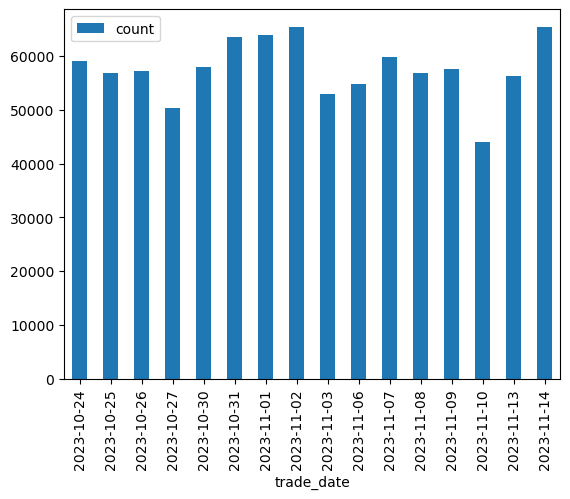

In [36]:
counts_per_trade_date = data_for_analysis.groupby('trade_date').count()
counts_per_trade_date['count'] = counts_per_trade_date.iloc[:, 0]
counts_per_trade_date = counts_per_trade_date[['count']]
counts_per_trade_date.plot.bar()

In [37]:
# plot line plots of accuracies of baseline vs up-to-date models
mae_per_trade_date = data_for_analysis.groupby('trade_date').mean()
mae_per_trade_date = mae_per_trade_date[['abs_error_up_to_date', 'abs_error_stale']]

Text(0, 0.5, 'MAE')

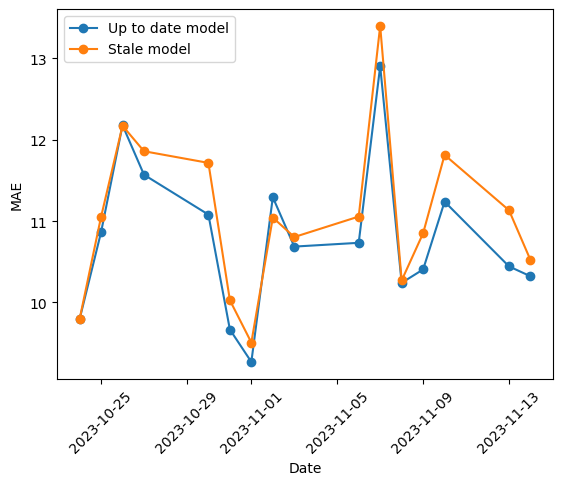

In [38]:
plt.plot(mae_per_trade_date.index, mae_per_trade_date['abs_error_up_to_date'], linestyle='-', marker='o', label='Up to date model')
plt.plot(mae_per_trade_date.index, mae_per_trade_date['abs_error_stale'], linestyle='-', marker='o', label='Stale model')
plt.xticks(rotation=45)
plt.legend()
plt.xlabel('Date')
plt.ylabel('MAE')
# plt.title('Stale model error is larger than an up to date model')

In [39]:
mae_per_trade_date

,abs_error_up_to_date,abs_error_stale
trade_date,,
2023-10-24,9.793196,9.793196
2023-10-25,10.862626,11.051690
2023-10-26,12.179503,12.172826
2023-10-27,11.570514,11.859679
2023-10-30,11.080299,11.716299
2023-10-31,9.667136,10.027463
2023-11-01,9.268695,9.507025
2023-11-02,11.294062,11.043791
2023-11-03,10.686911,10.804504
